# Police crime report analysis

## Modules

In [2]:
import pandas as pd
import numpy as np
import re # regular expressions
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from xgboost import plot_importance
from scipy import stats

In [26]:
# Fix random state for reproducibility
np.random.seed(0)

## Extract crime data

URL: "https://data.austintexas.gov/api/views/vmn9-3bvu/rows.csv?accessType=DOWNLOAD"

In [4]:
# read in dataset
df = pd.read_csv("//Users/Elliot/Documents/Projects/Crime_Reports/Crime_Reports_2018.csv")

# Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('-', '_')

Let's get an idea of what the data looks like.

In [5]:
pd.set_option('display.max_columns', 40)
print(df.shape) # show dimensions
df.head()

(102605, 27)


,incident_number,highest_offense_description,highest_offense_code,family_violence,occurred_date_time,occurred_date,occurred_time,report_date_time,report_date,report_time,location_type,address,zip_code,council_district,apd_sector,apd_district,pra,census_tract,clearance_status,clearance_date,ucr_category,category_description,x_coordinate,y_coordinate,latitude,longitude,location
0,201810852,POSSESSION OF MARIJUANA,1803,N,01/01/2018 05:26:00 AM,01/01/2018,526,01/01/2018 05:26:00 AM,01/01/2018,526,STREETS / HWY / ROAD / ALLEY,1800 N IH 35 SVRD NB,78753.0,7.0,CH,3,391.0,NaN,NaN,NaN,NaN,NaN,3118491.0,3118491.0,30.278294,-97.729293,"(30.27829428, -97.72929263)"
1,201810774,FAMILY DISTURBANCE,3400,N,01/01/2018 05:16:00 AM,01/01/2018,516,01/01/2018 05:16:00 AM,01/01/2018,516,RESTAURANTS,6300 E US 290 HWY WB,78752.0,4.0,ID,1,280.0,NaN,N,01/01/2018,NaN,NaN,3127294.0,3127294.0,30.322025,-97.700204,"(30.32202477, -97.70020416)"
2,201811735,TERRORISTIC THREAT-FAM/DAT VIO,2704,Y,01/01/2018 08:37:00 PM,01/01/2018,2037,01/01/2018 10:34:00 PM,01/01/2018,2234,RESIDENCE / HOME,5605 SPRINGDALE RD,78723.0,1.0,CH,4,324.0,NaN,C,01/02/2018,NaN,NaN,3135853.0,3135853.0,30.299304,-97.673696,"(30.29930398, -97.67369558)"
3,201811129,DISTURBANCE - OTHER,3401,N,01/01/2018 11:56:00 AM,01/01/2018,1156,01/01/2018 12:24:00 PM,01/01/2018,1224,DAYCARE FACILITY,8906 WALL ST,78754.0,1.0,ED,3,253.0,NaN,N,01/06/2018,NaN,NaN,3136206.0,3136206.0,30.342349,-97.671389,"(30.34234916, -97.67138944)"
4,201810867,FAMILY DISTURBANCE,3400,N,01/01/2018 05:51:00 AM,01/01/2018,551,01/01/2018 05:51:00 AM,01/01/2018,551,RESIDENCE / HOME,8312 FATHOM CIR,78750.0,6.0,AD,6,187.0,NaN,N,01/06/2018,NaN,NaN,3102221.0,3102221.0,30.436177,-97.776668,"(30.43617653, -97.77666832)"


## Data preprocessing
Some variables are redundant, so we need to remove them. We also need to transform the features that are related to dates to make them more informative.

In [6]:
# remove redundant features
redundant = ['incident_number', 'highest_offense_description', 'occurred_date_time', 
             'report_date_time', 'x_coordinate', 'y_coordinate', 'location']
df = df.drop(redundant, axis=1)

# date features that need expanding
dates = ['occurred_date', 'report_date', 'clearance_date']

# split date features into separate, day, month, and year features
for date in dates:
    df[date] = pd.to_datetime(df[date]) # convert to datetime format
    name = re.findall('.*_', date)[0]
    
    df[name + 'month'] = df[date].dt.month
    df[name + 'day'] = df[date].dt.day
    df[name + 'year'] = df[date].dt.year

# drop the year feature that is constant (i.e. always = 2018) and the date features that we split into new features
df = df.drop(['report_year'] + dates, axis=1)

## Handling missing data


In [7]:
# Check which features have the largest percentage of missing cases.
num_missing = df.isnull().sum()
percent_missing = num_missing / df.shape[0]
print(100*percent_missing)

highest_offense_code     0.000000
family_violence          0.000000
occurred_time            0.000000
report_time              0.000000
location_type            0.624726
address                  0.000000
zip_code                 0.859607
council_district         1.194874
apd_sector               0.564300
apd_district             0.596462
pra                      0.733882
census_tract            58.502997
clearance_status         9.315336
ucr_category            63.934506
category_description    63.934506
latitude                 2.290337
longitude                2.290337
occurred_month           0.000000
occurred_day             0.000000
occurred_year            0.000000
report_month             0.000000
report_day               0.000000
clearance_month          9.317285
clearance_day            9.317285
clearance_year           9.317285
dtype: float64


We can see that census_tract, ucr_category, and category_description contain the majority of the missing cases, so if we remove those features, we can minimize data loss when we remove incomplete cases.

In [8]:
# Save the initialize data dimensionals so we can see how much data we lose by removing cases
initial_dims = df.shape

# Drop columns with a high proportion of NaNs
df = df.drop(["census_tract", "ucr_category"], axis=1)
df = df.dropna(subset=['category_description']) # this is going to be our response variable (spoilers)

# Check the percentage of observations we would lose if we dropped missing cases
percent_lost = 1 - df.shape[0] / initial_dims[0]
print("Percentage of observations lost:", '{:.3}'.format(percent_lost))

Percentage of observations lost: 0.639


So, if we were to remove rows with missing cases in the response ('category_description') we would lose roughly 64% of the observations. For the remaining data, we can try data imputation to prevent more data loss.

In [9]:
# check how many missing cases are remaining
df.isnull().sum()

highest_offense_code       0
family_violence            0
occurred_time              0
report_time                0
location_type            176
address                    0
zip_code                 167
council_district         261
apd_sector               110
apd_district             115
pra                      116
clearance_status        1338
category_description       0
latitude                 945
longitude                945
occurred_month             0
occurred_day               0
occurred_year              0
report_month               0
report_day                 0
clearance_month         1338
clearance_day           1338
clearance_year          1338
dtype: int64

Before handling the rest of the missing cases, it will be helpful to do some bookkeeping.

In [10]:
# Some features need to be converted to categorical
cat_tmp = ['highest_offense_code', 'zip_code', 'apd_district', 'pra']
for feature in cat_tmp:
    df[feature] = pd.Categorical(df[feature])

# Slice the dataframe into separate numeric and categorical copies to help with bookkeeping
cat_df = df.select_dtypes(include=['object', 'category']).columns
num_df = df.select_dtypes(include=['int64','float64']).columns

Instead of removing missing cases from the remaining features, we will use imputation to substitute missing cases. Though model based imputation is typically more robust, given the size of the data and my
available computing power (an anciant laptop), I decided to use median imputation for numeric features and most frequent imputation for categorical.

In [11]:
num_idx = [df.columns.get_loc(i) for i in num_df]
cat_idx = [df.columns.get_loc(i) for i in cat_df]

# median numeric and most frequent categorical  missing value imputation
t = [('num', SimpleImputer(strategy='median'), num_idx), 
     ('cat', SimpleImputer(strategy='most_frequent'), cat_idx)]
transformer = ColumnTransformer(transformers=t)
X = transformer.fit_transform(df)
column_names = np.concatenate((num_df, cat_df))
X = pd.DataFrame(X, columns = column_names)

In [12]:
# convert categorical features to numeric
for column in cat_df:
    X[column] = pd.Categorical(X[column])
    X[column] = X[column].cat.codes

for column in num_df:
    X[column] = pd.to_numeric(X[column])

In [13]:
# take a look at the data after transformations
X.head()

,occurred_time,report_time,council_district,latitude,longitude,occurred_month,occurred_day,occurred_year,report_month,report_day,clearance_month,clearance_day,clearance_year,highest_offense_code,family_violence,location_type,address,zip_code,apd_sector,apd_district,pra,clearance_status,category_description
0,1300.0,1409.0,6.0,30.457103,-97.767100,12.0,31.0,2017.0,1.0,1.0,1.0,2.0,2018.0,23,0,30,2923,22,1,3,480,1,6
1,2240.0,14.0,1.0,30.365319,-97.608693,12.0,31.0,2017.0,1.0,1.0,2.0,15.0,2018.0,19,0,32,11001,3,4,7,114,1,2
2,2134.0,2134.0,7.0,30.349092,-97.734751,1.0,1.0,2018.0,1.0,1.0,1.0,26.0,2018.0,11,0,11,12458,46,10,6,148,1,0
3,1700.0,1540.0,6.0,30.431761,-97.762820,12.0,31.0,2017.0,1.0,1.0,1.0,4.0,2018.0,37,0,31,2504,20,1,2,75,1,1
4,1700.0,1727.0,9.0,30.266100,-97.744003,1.0,1.0,2018.0,1.0,1.0,1.0,2.0,2018.0,22,0,14,7252,6,8,3,276,1,6


## Standardizing the data

Standardization allows us to compare features with different units and can improve the numerical stability of some algorithms.

In [16]:
# subtract the mean and divide by the standard deviation of each column
for column in X.columns:
    X[column] = stats.zscore(X[column]) 

## Exploratory data analysis

Pairwise scatter plots help find general trends in the data, but they are especially useful for finding nonlinear trends which will help when it comes time to do feature engineering. To ease the computational cost and make the plot less noisy, I plotted a random sample of the observations.

I combed through the entire 23 x 23 scatter plot matrix, but I'll spare you the pain by only including features that seemed to have some nonlinearities or strange relationships.

In [17]:
X_subset = X.sample(n = 1000, replace = False) # randomly sample rows from X

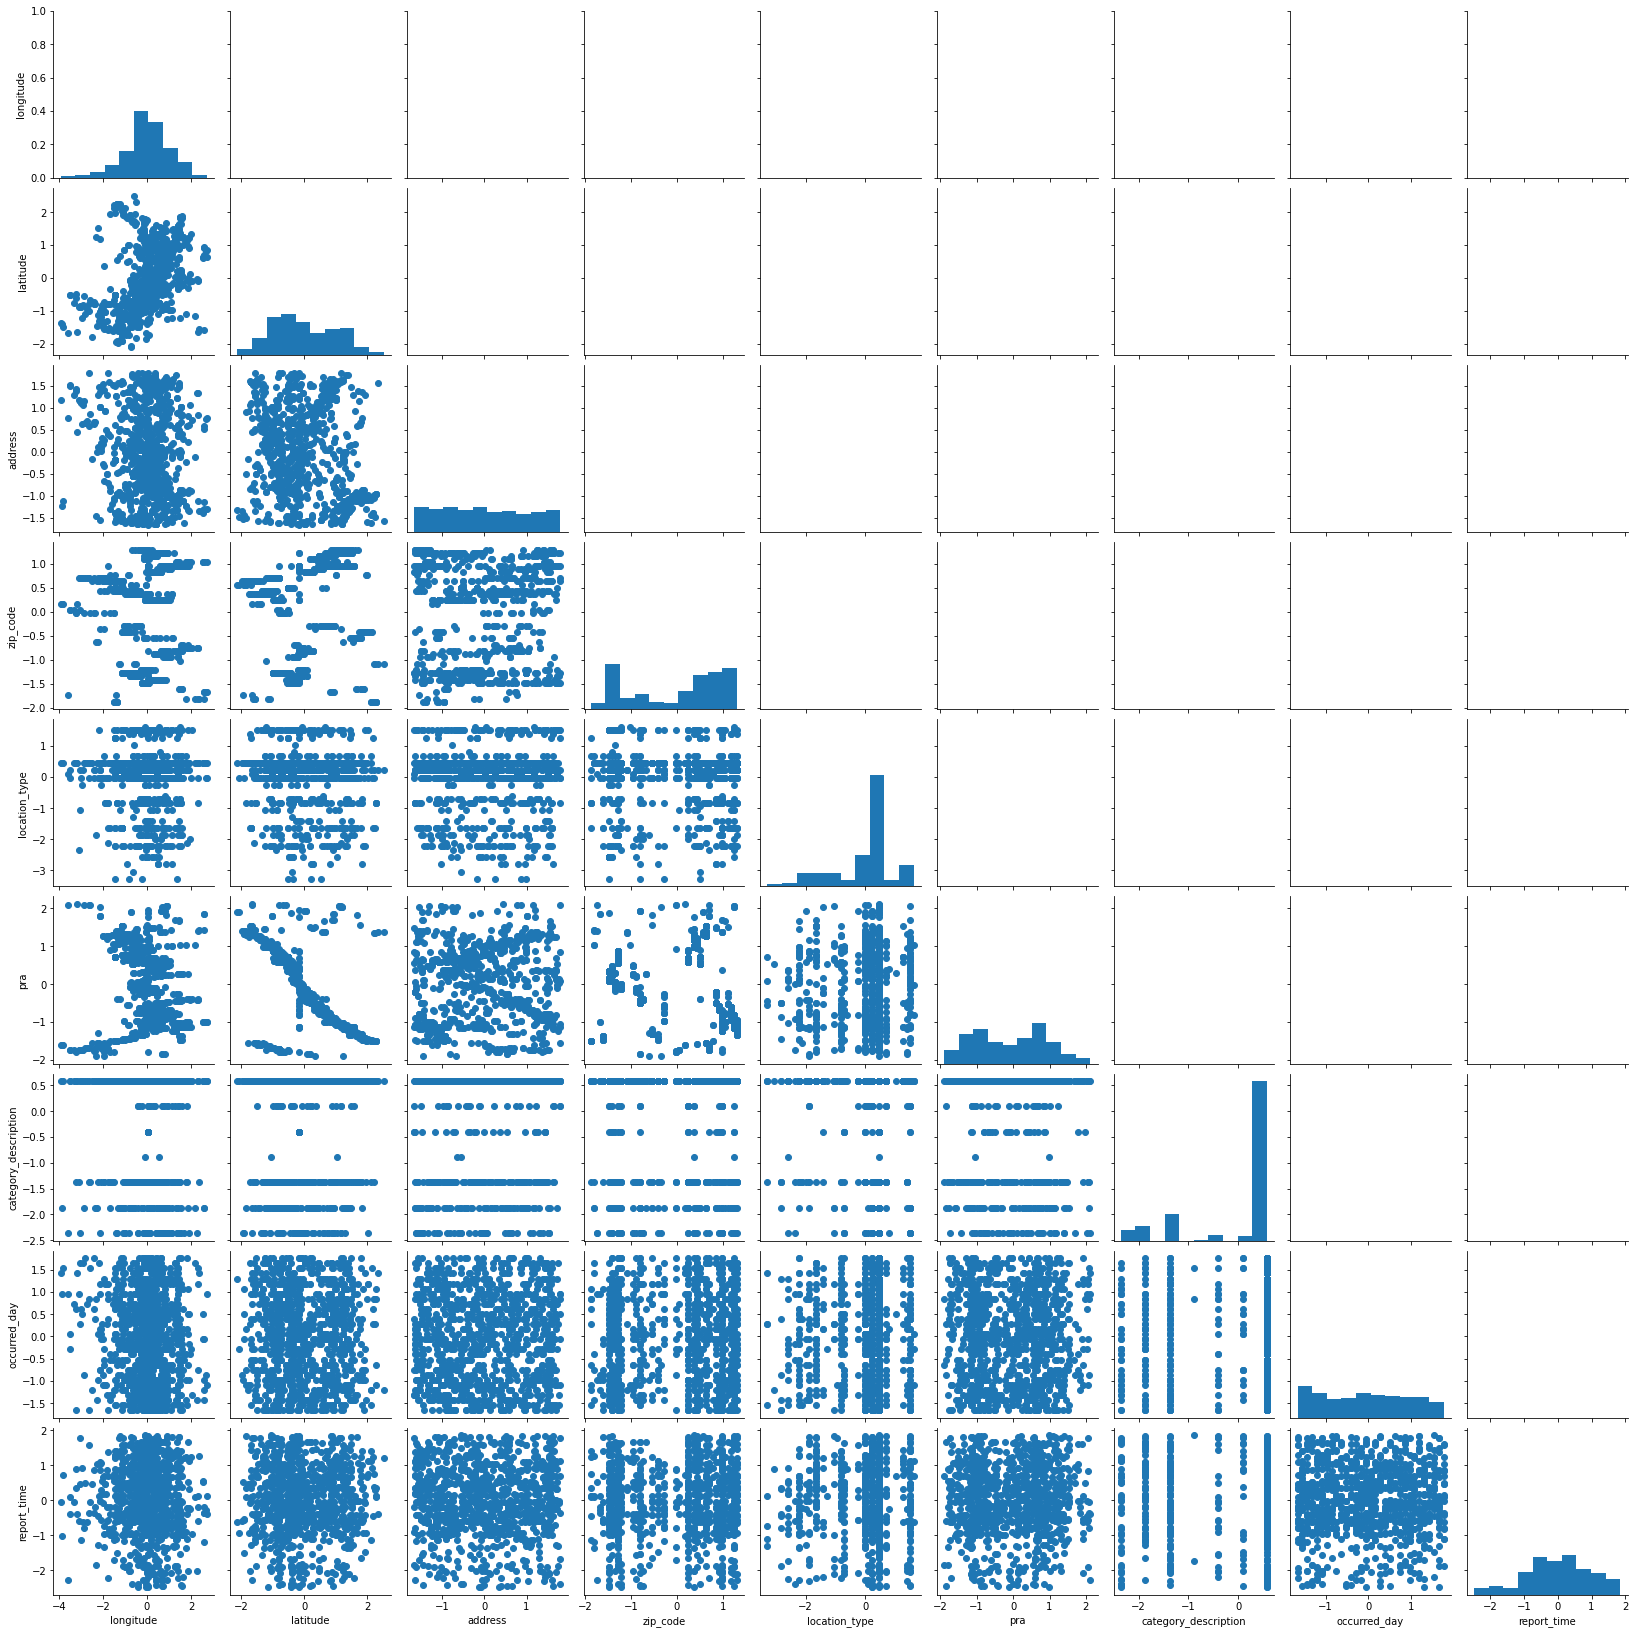

In [18]:
# features that seemed ot have some nonlinear relationships
interesting_features = ['longitude', 'latitude','address', 'zip_code', 'location_type', 
                        'pra', 'category_description', 'occurred_day', 'report_time']

# pairwise scatter plots and histograms
g = sns.PairGrid(X_subset[interesting_features])
g = g.map_diag(plt.hist)
g = g.map_lower(plt.scatter)

There appear to be some nonlinearities (such as 'longitude by pra' and 'longitude by latitude') that we may want to account for later.

<AxesSubplot:>

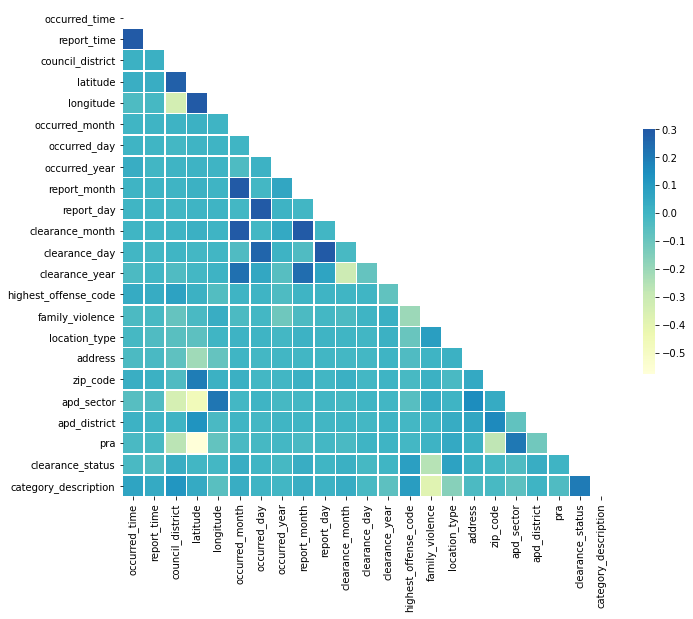

In [19]:
# Compute the correlation matrix
corr = X.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='YlGnBu', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

From these plot we can see that many of the features that deal with dates are correlated and many of the location features are correlated.

I want to explore the feature 'category_description,' which describes the type of crime committed. So, it may be helpful to use principle components analysis to explore the feature space. If we're lucky 'category_description' will be well separated along the principle components (i.e., directions of maximum variance). In addition, we may be able to reduce the dimensionality of the dataset if most of the variance can be explained by fewer components.

Variance explained for each component:
[0.11814566 0.10121988 0.08996814 0.07588332 0.0647656  0.06208567
 0.0560509  0.05341692 0.0474159  0.04366255 0.03855353 0.03629171
 0.03353247 0.03189495 0.02712122 0.02569674 0.02554287 0.02506723
 0.01993053 0.00969503 0.00768273 0.00438542 0.00199105]


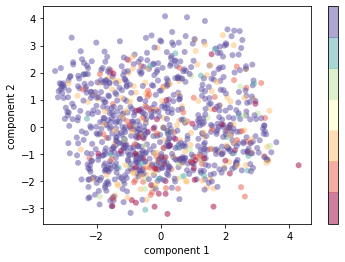

In [20]:
# PCA plot from: https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

num_comps = X_subset.shape[1]
pca = PCA(n_components=num_comps, svd_solver='randomized')
projected = pca.fit_transform(X_subset)
print('Variance explained for each component:')
print(pca.explained_variance_ratio_)

classes = df.category_description.unique()
plt.scatter(projected[:, 0], projected[:, 1],
            c=X_subset.category_description, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', len(classes)))
plt.xlabel('component 1')
plt.ylabel('component 2')
cbar=plt.colorbar() 
cbar.set_ticks(range(1,7))

It looks like we've had poor luck for both the goals of our PCA. The variance explained is spread out over most of the components, and the classes (colors) of 'category_description' do not separate well along the first and second principal components. Therefore, we won't use the principle components as our new features and instead proceed with our original features.

<AxesSubplot:>

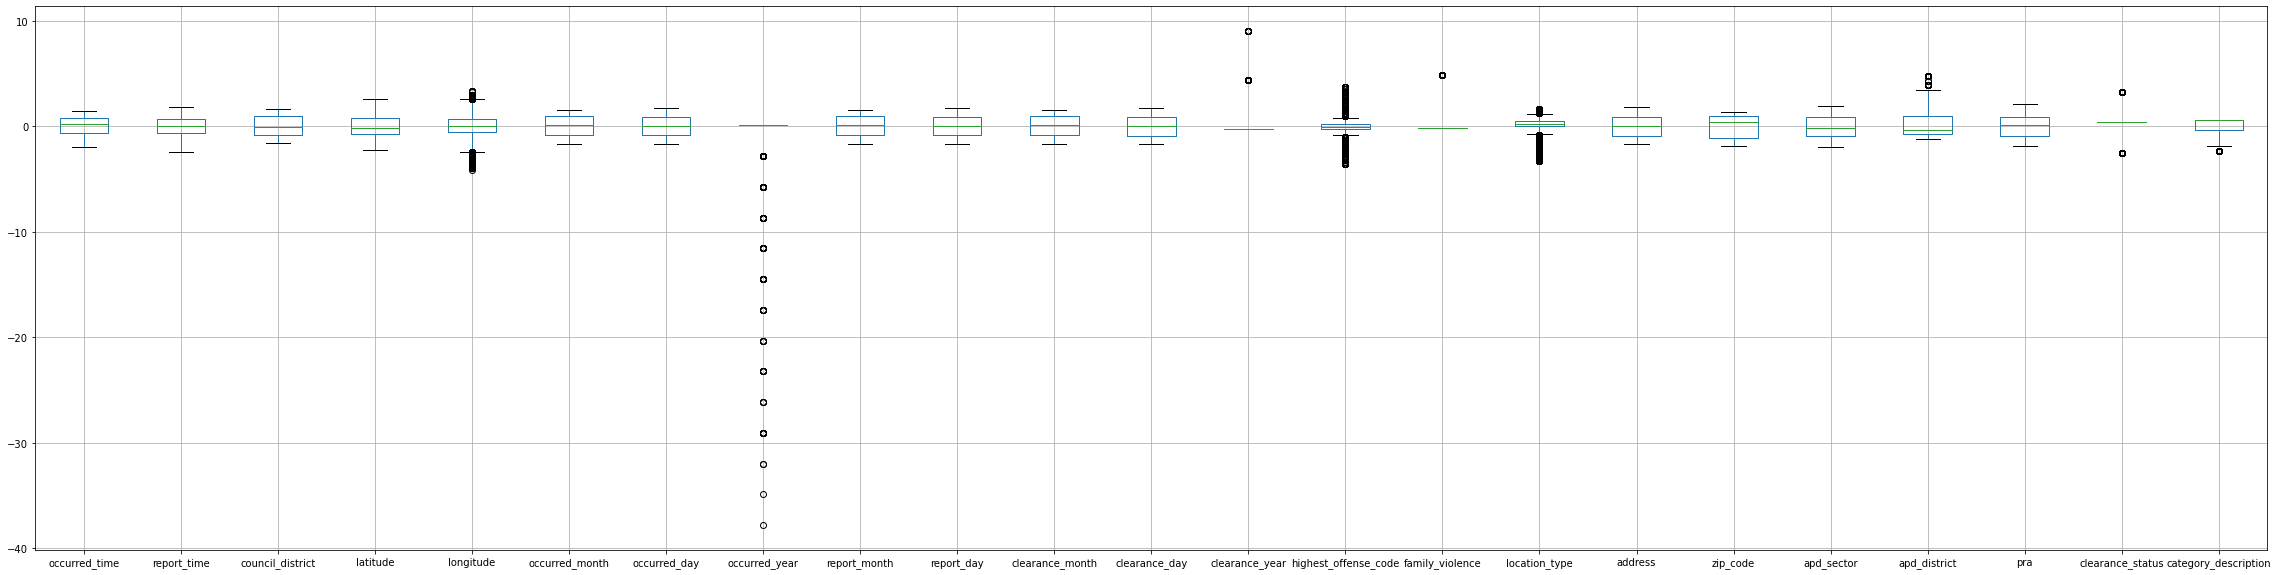

In [21]:
# Outlier detection: boxplots
X.boxplot(figsize=(40,10))

Though some of the features have outliers, Generally, I do not like excluding outliers because they may be legitimate data. So, without more meta-data telling me that the outliers are something like incorrect data entries, I won't exclude them from the analysis. If I'm worried about outliers, I will use a method that is robust to outliers, such as lasso regression.

## The prediction task

I'm interested in predicting 'category_description' of the crime because I suspect that it will vary considerably by location. I hypothesize that areas with lower economic status may be affected by different crimes than areas with higher economic status.  So, we would expect location data to predict the type of crime committed. Time features may also predict the class of crime that occurs, but I suspect that only locally relevant time features (e.g., time of day) would predict the crime class well and wouldn't expect there to be trends on a larger time scale (months, years).

In [22]:
# Let's take a look at the classes in category_description
df.category_description.value_counts()

Theft                 26529
Burglary               4158
Auto Theft             2417
Aggravated Assault     2075
Robbery                 998
Rape                    797
Murder                   31
Name: category_description, dtype: int64

In [23]:
X['category_description'] = pd.Categorical(X['category_description'])
y = X.category_description.cat.codes

# highest_offense_code is a redundant encoding of category_description
X = X.drop(['category_description', 'highest_offense_code'], axis=1) 

I dropped 'highest_offense_code' code because it perfectly predicted 'category_description' in some models.

## Feature engineering

I suspect that there could be some interactions between the location and time features, so it may be beneficial to add some time by location interaction terms in the model. We will use the features we found using the scatter plots in the exploratory analysis step.

In [24]:
# read update (above) for why code is not included in the analysis

# Feature interactions
poly = PolynomialFeatures(interaction_only=True,include_bias = False) # creates interactions terms for all 'interesting' features
interesting_features.remove('category_description') # response variable, so exclude it
interactions = poly.fit_transform(X[interesting_features])
names = poly.get_feature_names(X.columns)
interactions = pd.DataFrame(interactions, columns = names)
interactions = interactions.iloc[:,8:]

In [25]:
# combine original features with interaction terms
X.reset_index(drop=True, inplace=True)
interactions.reset_index(drop=True, inplace=True)
X = pd.concat([X, interactions], axis=1)

## Model building

To get a base line, we'll start with a logistic regression. Then we will try a more flexible model, XGBoost, and compare.

In [369]:
# logistic regression model (with l2 penalty for regularization)
lr = LogisticRegression(penalty='l2', random_state=1, solver='lbfgs', max_iter=1000)

# Extreme gradient boosting
xgb = XGBClassifier(gamma=5) # gamma is a regularization parameter

## Model validation

In [370]:
# split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1)

In [375]:
# k-folds cross validation accuracy. 
# Warning: this takes awhile (on my old laptop)

# logistic regression
scores = cross_val_score(lr, X_train, y_train, cv=5)
print("Logistic regression CV accuracy: %0.2f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

# XGBoost
scores = cross_val_score(xgb, X_train, y_train, cv=5)
print("XGBoost CV accuracy: %0.2f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

Logistic regression CV accuracy: 0.75 (+/- 0.0052)
XGBoost CV accuracy: 0.78 (+/- 0.0019)


In [376]:
# test-set accuracy

# logistic regression
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
test_accuracy1 = lr.score(X_test, y_test)
print('Logistic regression testset Accuracy:', '{:.3}'.format(test_accuracy1))

# XGBoost
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
test_accuracy2 = xgb.score(X_test, y_test)
print('XGBoost testset Accuracy:', '{:.3}'.format(test_accuracy2))

Logistic regression testset Accuracy: 0.751
XGBoost testset Accuracy: 0.778


Surprisingly, the difference between the test error of the simple and complex model is small. Therefore, which model we choose would depend on the level of interpretability require by the task at hand, with the logistic regression being relatively straightforward to interpret and XGBoost less so.

Though 77% accuracy is nothing to scoff at, the likely reason the model didn't perform better is that the classes in 'categorgy_description' are not well separated in the feature space. We should have anticipated this since we wouldn't expect particular types of crimes to be totally restricted to specific times and locations.

I tuned XGBoost's hyperparameters but found that tuning barely affected the fit. Ultimately, I left the hyperparameters to their defaults (aside from the regularization parameter, gamma).

A convenient feature of XGBoost (and most tree-based models) is that we can easily calculate metrics of variable importance to see which features are the best predictors of the crime category.

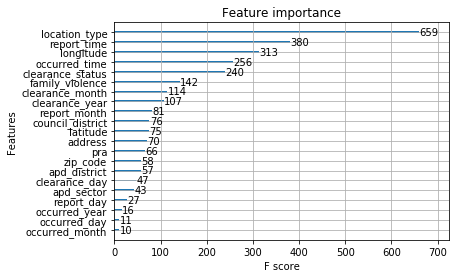

In [377]:
# plot feature importance
plot_importance(xgb)

As I had hypothesized, features related to the crime location were strong predictors of the type of crime committed. Location type is likely such a strong predictor of the type of crime because we would expect different crimes at say bars (e.g., assault) than in commercial areas (e.g., theft). Some of the time features (like report time) also strongly predicted the crime class. This is likely because crimes are temporally stratified between day and night crimes.

This model could be used to predict the types of crimes that will occur more in certain areas and times of the day. Police could use these insights to allocate law enforcement units to these areas at times of high crime incidence to optimize police resources.